In [1]:
import torch
from torch import Tensor
from torch import optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
from torch.nn.functional import softmax
import torchvision.transforms as tt

from tqdm import tqdm

from CNNmodel import ConvModel

from utils import CustomDataSet, load_data, print_config, DeviceDataLoader, supervised_samples, calc_mean_std, plotting, get_PATH
import config


In [2]:
print_config()

RANDOM_SEED  :   110404
DATA_DIR     :   ./data
USED_DATA    :  CIFAR10
NUM_LABELLED :       -1
DEVICE       :   cuda:0
EPOCHS       :       50
BATCH_SIZE   :      512
LEARNING_RATE:     0.01


In [3]:
torch.manual_seed(config.RANDOM_SEED)

In [4]:
name = "CNN"

In [5]:
PATH = get_PATH(name)
PATH

'CIFAR10/CNN'

In [6]:
X_train, y_train, X_test, y_test, classes = load_data(0, 1)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
n_classes = len(classes)
channels = X_train.shape[1]
n_classes, channels

(10, 3)

In [9]:
X_train, y_train = supervised_samples(X_train, y_train, config.NUM_LABELLED, n_classes)

In [10]:
y_train = y_train.type(torch.ByteTensor)
y_test = y_test.type(torch.ByteTensor)

In [11]:
mean, std = calc_mean_std(X_train)
mean, std

([0.4913996927399561, 0.4821584222899936, 0.4465309280202538],
 [0.24703270196914673, 0.24348430335521698, 0.261587530374527])

In [12]:
if config.USED_DATA == "CIFAR10":

	train_tfm = tt.Compose([
		tt.RandomCrop(32, padding=4, padding_mode='edge'),
		tt.RandomHorizontalFlip(),
		tt.Normalize(mean, std, inplace=True)
	])

if config.USED_DATA == "MNIST":
	train_tfm = tt.Compose([
		tt.Normalize(mean, std, inplace=True)
	])

valid_tfm = tt.Compose([
	tt.Normalize(mean, std)
])

In [13]:
train_ds = CustomDataSet(X_train, y_train, train_tfm)
valid_ds= CustomDataSet(X_test, y_test, valid_tfm)

In [14]:
def show_image(img, label):
	print("Label: ("+str(label)+")")
	plt.imshow(img.permute(1,2,0))

In [15]:
train_dl = DataLoader(train_ds, config.BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, config.BATCH_SIZE, num_workers=3, pin_memory=True)

In [16]:
def show_batch(dl: DataLoader):
	for images, labels in dl:
		fig,ax= plt.subplots(figsize=(12,12))
		ax.set_xticks([])
		ax.set_yticks([])
		ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
		break # printing only first 64 images from first batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


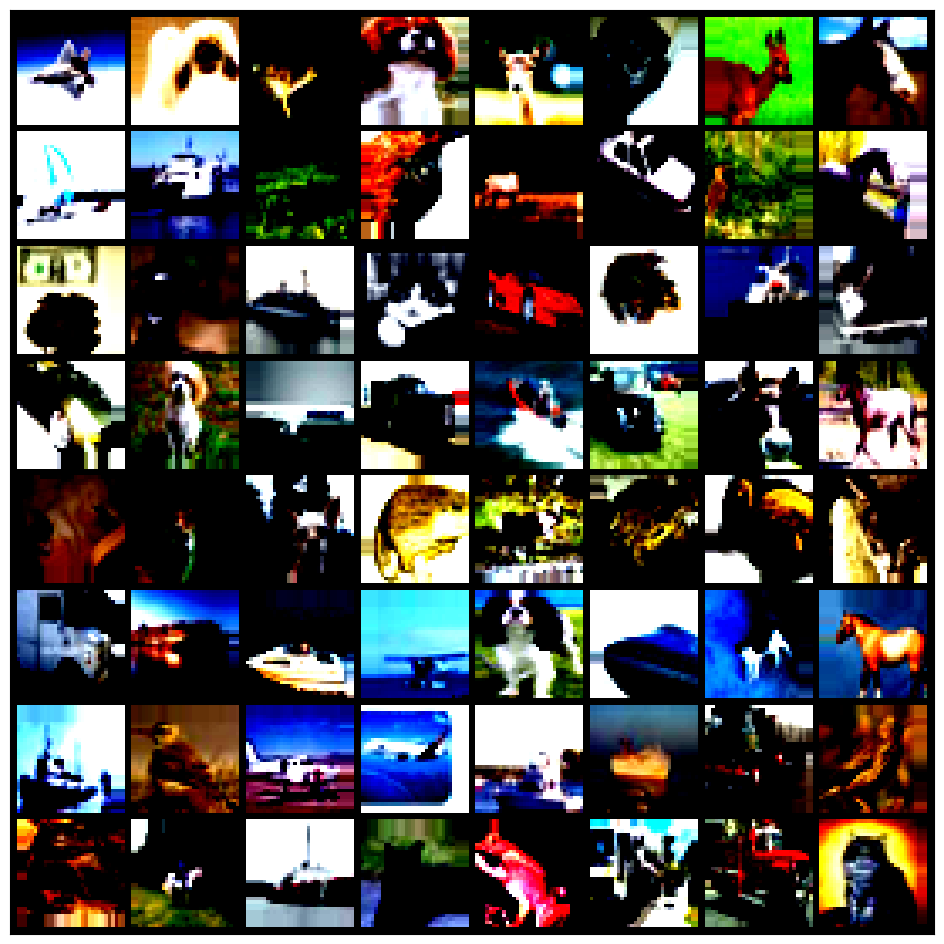

In [17]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


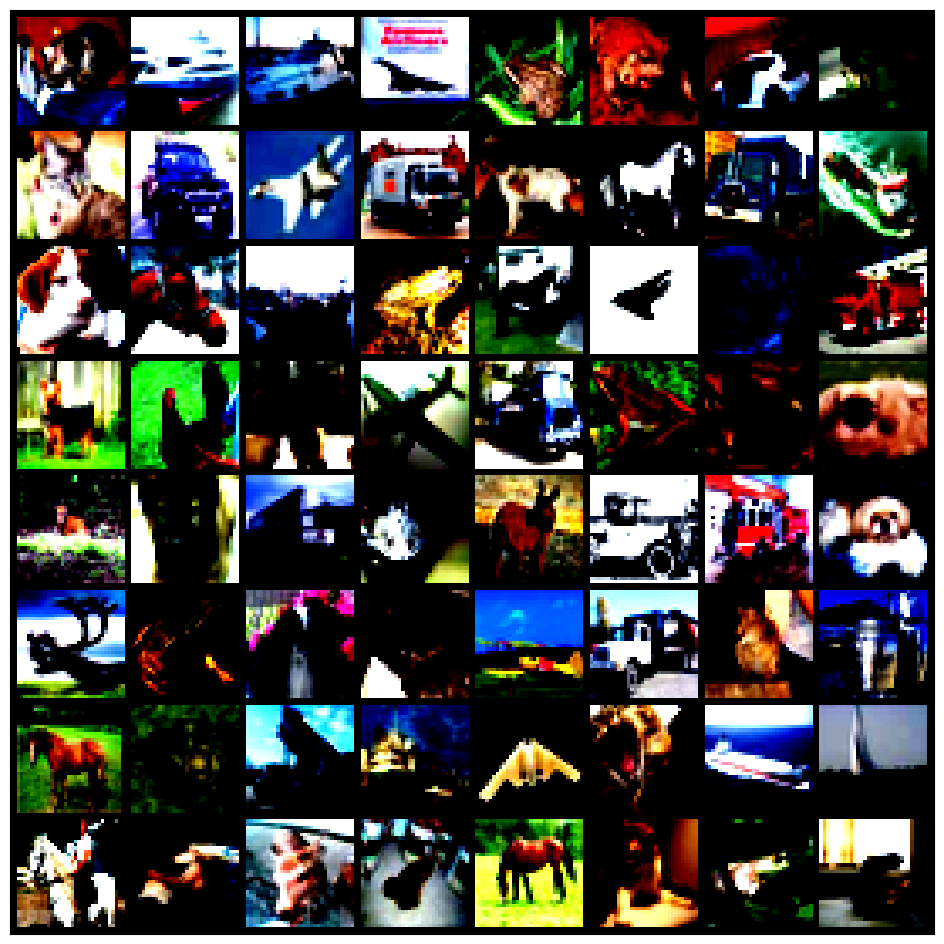

In [18]:
show_batch(valid_dl)

In [19]:
train_dl = DeviceDataLoader(train_dl, config.DEVICE)
valid_dl = DeviceDataLoader(valid_dl, config.DEVICE)

In [20]:
class Model(nn.Module):
	def __init__(self, in_channels, num_classes):
		super().__init__()

		self.conv = ConvModel(in_channels)
		
		self.classifier = nn.Linear(512, num_classes)

		self.criterion = nn.CrossEntropyLoss()
		
	def forward(self, X: Tensor):
		if X.dim() == 3:
			X = X.unsqueeze(0)
		out = self.conv(X)
		out = self.classifier(out)
		return out
	
	@staticmethod
	def corrected(outputs, labels):
		_, preds = torch.max(outputs, dim=1)
		return torch.tensor(torch.sum(preds == labels).item())
	
	@torch.no_grad()
	def evaluate(self, loader: DeviceDataLoader):
		self.eval()

		total_loss = 0
		total_corrected = 0

		for batch in loader:
			loss, corrected = self.step(batch)

			total_loss += loss.detach()
			total_corrected += corrected

		n = loader.num_data()

		return (total_loss/len(loader)).item(), (total_corrected/n).item()
		
	@staticmethod
	def get_lr(optimizer: optim.Optimizer):
		for param_group in optimizer.param_groups:
			return param_group['lr']

	def step(self, batch) -> tuple[Tensor, Tensor]:
		images, labels = batch 
  
		outs = self(images)                  
		loss = self.criterion(outs, labels) 

		corrected = self.corrected(outs, labels)

		return loss, corrected


	def fit(self, epochs, max_lr, train_loader: DeviceDataLoader, val_loader: DeviceDataLoader, weight_decay=0, grad_clip=None, opt_func: optim.Optimizer = optim.SGD, sched = True, PATH = "./", save_best = True):
		if config.DEVICE == 'cuda:0':
			torch.cuda.empty_cache()
		
		history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lrs': []}

		optimizer: optim.Optimizer = opt_func(self.parameters(), max_lr, weight_decay=weight_decay)

		if sched:

			OneCycleLR = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

		best_val = 0

		for epoch in range(epochs):
			self.train()
			train_loss = 0
			train_acc = 0
			lrs = []

			print(f"Epoch [{epoch}]")

			for batch in tqdm(train_loader):

				loss, corrected = self.step(batch)

				train_loss += loss.detach()
				
				train_acc += corrected

				loss.backward()

				if grad_clip:
					nn.utils.clip_grad_value_(self.parameters(), grad_clip)
				
				optimizer.step()
				optimizer.zero_grad()

				if sched:
					OneCycleLR.step()

				lrs.append(self.get_lr(optimizer))
			
			val_loss, val_acc = self.evaluate(val_loader)
			train_loss = (train_loss/len(train_loader)).item()
			train_acc = (train_acc/train_loader.num_data()).item()


			

			history['val_loss'].append(val_loss)
			history['val_acc'].append(val_acc)
			history['train_loss'].append(train_loss)
			history['train_acc'].append(train_acc)
			history['lrs'] += lrs


			print(f"train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, lrs: {lrs[0]:.4f}->{lrs[-1]:.4f}")

			if val_acc >= best_val:
				if save_best:
					torch.save(self.state_dict(), PATH)
				
				best_val = val_acc
		
		return history
				

In [21]:
model = Model(channels, n_classes).to(config.DEVICE, non_blocking=True)

In [22]:
history = model.fit(config.EPOCHS, config.LEARNING_RATE, train_dl, valid_dl, weight_decay=0, grad_clip=None, opt_func=optim.Adam, sched=True, PATH=PATH+".pt", save_best=True)

Epoch [0]


100%|██████████| 98/98 [00:18<00:00,  5.35it/s]


train_loss: 1.4110, val_loss: 1.0699, train_acc: 0.5063, val_acc: 0.6319, lrs: 0.0004->0.0005
Epoch [1]


100%|██████████| 98/98 [00:18<00:00,  5.38it/s]


train_loss: 0.9669, val_loss: 0.9343, train_acc: 0.6698, val_acc: 0.6748, lrs: 0.0005->0.0008
Epoch [2]


100%|██████████| 98/98 [00:18<00:00,  5.35it/s]


train_loss: 0.7790, val_loss: 0.7670, train_acc: 0.7361, val_acc: 0.7356, lrs: 0.0008->0.0013
Epoch [3]


 32%|███▏      | 31/98 [00:06<00:13,  5.15it/s]


KeyboardInterrupt: 

In [23]:
model.load_state_dict(torch.load(PATH + ".pt"))

<All keys matched successfully>

In [24]:
model.evaluate(valid_dl)

(0.481386661529541, 0.8575000166893005)

tensor([4], device='cuda:0')


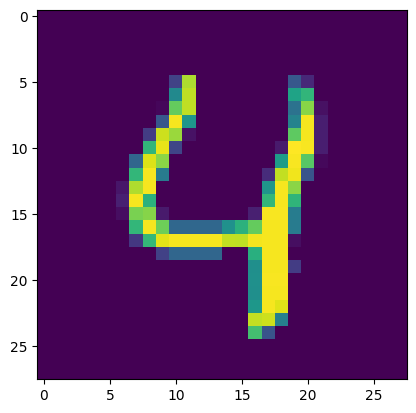

In [131]:
test = 4
out = model(valid_ds[test][0].unsqueeze(0).cuda())
_, pred = torch.max(out, dim=1)

print(pred)

plt.imshow(X_test[test].permute(1, 2, 0))


In [26]:
import pickle

In [24]:
with open(PATH + ".pickle", 'wb') as f:
	pickle.dump(history, f)

In [24]:
with open(PATH + ".pickle", 'rb') as f:
	history = pickle.load(f)

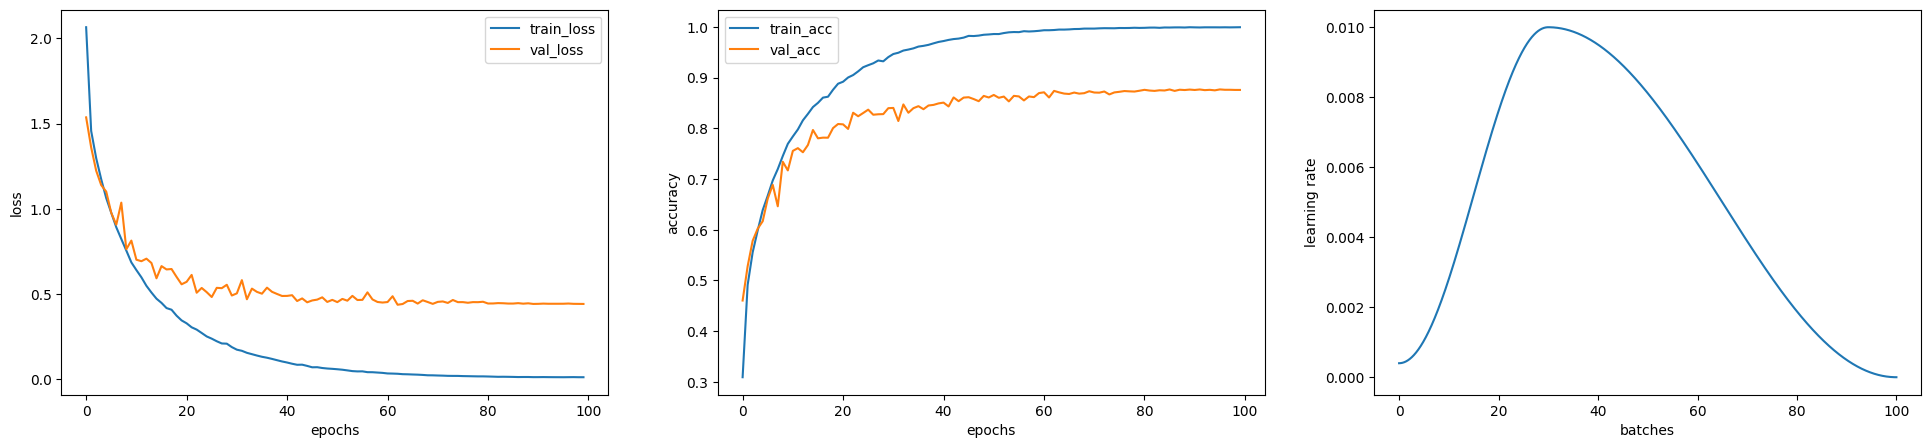

In [25]:
plotting(history, True)